<a href="https://colab.research.google.com/github/harsha5428/LLM/blob/main/Assign3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
!pip install datasets matplotlib seaborn pandas transformers torch vaderSentiment
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
# Import necessary libraries
!pip install datasets matplotlib seaborn pandas transformers torch vaderSentiment
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Download NLTK data
nltk.download('punkt')



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Define a class for Climate Sentiment Analysis
class ClimateSentimentAnalysis:
    def __init__(self, model_dir=None):
        # Load dataset and convert to pandas
        self.dataset_clim = load_dataset("climatebert/climate_detection")
        self.train_data_clim = self.dataset_clim["train"].to_pandas()
        self.test_data = self.dataset_clim["test"].to_pandas()
        self.tokenizer = None
        self.model = None
        self.model_dir = model_dir or './saved_model'

        # Create model directory if it doesn't exist
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            print(f"Directory '{self.model_dir}' created.")
        else:
            print(f"Directory '{self.model_dir}' already exists.")

    def data_overview(self):
        print("Train_Data _Shape:", self.train_data_clim.shape)
        print("Test_Data_Shape:", self.test_data.shape)

    def plot_class_distribution(self):
        plt.figure(figsize=(8, 6))
        sns.countplot(x='label', data=self.train_data_clim)
        plt.title("Class Distribution in Training Data")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.show()

    def plot_text_length_distribution(self):
        self.train_data_clim['text_len'] = self.train_data_clim['text'].apply(len)
        plt.figure(figsize=(8, 6))
        sns.histplot(self.train_data_clim['text_len'], bins=50)
        plt.title("Text Length Distribution in Training Data")
        plt.xlabel("Text Length")
        plt.ylabel("Frequency")
        plt.show()

    def generate_word_cloud(self):
        all_words_clim = []
        for sentence in self.train_data_clim['text']:
            all_words_clim.extend(word_tokenize(sentence.lower()))

        stopwords_clim = set(STOPWORDS)
        stopwords_clim.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
        filtered_words = [word for word in all_words_clim if word not in stopwords_clim and word.isalnum()]

        freq_dist = FreqDist(filtered_words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Training Data")
        plt.show()

    def generate_label_word_clouds(self):
        climate_words = []
        non_climate_words = []
        stopwords_clim = set(STOPWORDS)

        for _, row in self.train_data_clim.iterrows():
            words = word_tokenize(row['text'].lower())
            if row['label'] == 1:
                climate_words.extend(words)
            else:
                non_climate_words.extend(words)

        climate_freq_dist = FreqDist([word for word in climate_words if word not in stopwords_clim and word.isalnum()])
        non_climate_freq_dist = FreqDist([word for word in non_climate_words if word not in stopwords_clim and word.isalnum()])

        climate_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(climate_freq_dist)
        non_climate_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_climate_freq_dist)

        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(climate_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Climate Change Discussions")

        plt.subplot(1, 2, 2)
        plt.imshow(non_climate_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud for Non-Climate Change Discussions")

        plt.show()

    def keyword_stats(self):
        terms = ["climate", "warming", "emissions", "carbon", "energy", "sustainability"]

        for term in terms:
            climate_term_count = sum(self.train_data_clim[self.train_data_clim['label'] == 1]['text'].str.lower().str.contains(term))
            non_climate_term_count = sum(self.train_data_clim[self.train_data_clim['label'] == 0]['text'].str.lower().str.contains(term))

            climate_percentage = (climate_term_count / len(self.train_data_clim[self.train_data_clim['label'] == 1])) * 100
            non_climate_percentage = (non_climate_term_count / len(self.train_data_clim[self.train_data_clim['label'] == 0])) * 100

            print(f"Keyword '{term}':")
            print(f"  - Appears in {climate_percentage:.2f}% of climate change texts")
            print(f"  - Appears in {non_climate_percentage:.2f}% of non-climate change texts")
            print("-" * 30)

    def analyze_sentiment(self):
        sentiment_analyzer = SentimentIntensityAnalyzer()
        self.train_data_clim['sentiment'] = self.train_data_clim['text'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])
        self.test_data['sentiment'] = self.test_data['text'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

        plt.figure(figsize=(8, 6))
        sns.histplot(self.train_data_clim['sentiment'], bins=50)
        plt.title("Sentiment Distribution in Training Data")
        plt.xlabel("Sentiment Score")
        plt.ylabel("Frequency")
        plt.show()

        plt.figure(figsize=(8, 6))
        sns.boxplot(x='label', y='sentiment', data=self.train_data_clim)
        plt.title("Sentiment by Label in Training Data")
        plt.xlabel("Label")
        plt.ylabel("Sentiment Score")
        plt.show()

    def categorize_and_analyze_sentiment(self):
        def sentiment_category(score):
            if score >= 0.05:
                return 'Positive'
            elif score <= -0.05:
                return 'Negative'
            else:
                return 'Neutral'

        self.train_data_clim['sentiment_cat'] = self.train_data_clim['sentiment'].apply(sentiment_category)

        sentiment_proportions = self.train_data_clim.groupby(['label', 'sentiment_cat'])['text'].count() / self.train_data_clim.groupby('label')['text'].count()
        print(sentiment_proportions)

        sentiment_proportions.unstack().plot(kind='bar', figsize=(10, 6))
        plt.title("Sentiment Category Proportions by Label")
        plt.xlabel("Label (0: No Climate Change, 1: Climate Change)")
        plt.ylabel("Proportion")
        plt.legend(title="Sentiment Category")
        plt.show()

    def keyword_sentiment_analysis(self):
        terms = ["climate", "warming", "emissions", "carbon", "energy", "sustainability", "risk", "opportunity", "action", "crisis"]

        keyword_sentiment_df = pd.DataFrame()
        for term in terms:
            term_df = self.train_data_clim[self.train_data_clim['text'].str.lower().str.contains(term)]
            term_sentiment_counts = term_df.groupby(['label', 'sentiment_cat'])['text'].count()
            term_sentiment_proportions = term_sentiment_counts / term_df.groupby('label')['text'].count()
            temp_df = term_sentiment_proportions.unstack().fillna(0)
            temp_df['keyword'] = term
            keyword_sentiment_df = pd.concat([keyword_sentiment_df, temp_df])

        keyword_sentiment_df = keyword_sentiment_df.reset_index().set_index(['keyword', 'label'])

        plt.figure(figsize=(12, 8))
        sns.heatmap(keyword_sentiment_df, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Keyword-Sentiment Correlation Heatmap")
        plt.xlabel("Sentiment Category")
        plt.ylabel("Keyword (Label)")
        plt.show()

    def train_classifier(self):
        model_name = "bert-base-uncased"
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        def tokenize_batch(batch):
            return self.tokenizer(batch["text"], truncation=True, padding="longest")

        tokenized_data = self.dataset_clim.map(tokenize_batch, batched=True)

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        train_dataset_clim = tokenized_data["train"]
        test_dataset_clim = tokenized_data["test"]

        training_args = TrainingArguments(
            output_dir=f'{self.model_dir}/results',
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=5,
            weight_decay=0.01,
        )

        trainer_clim = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset_clim,
            eval_dataset=test_dataset_clim,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_eval_metrics,
        )

        trainer_clim.train()
        trainer_clim.save_model(self.model_dir)
        print(f"Model saved at '{self.model_dir}'.")

    def compute_eval_metrics(self, predictions):
        label_ids = predictions.label_ids
        pred_ids = np.argmax(predictions.predictions, axis=1)
        accuracy = accuracy_score(label_ids, pred_ids)
        precision, recall, f1, _ = precision_recall_fscore_support(label_ids, pred_ids, average='weighted')
        return {
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def evaluate_classifier(self):
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_dir)

        def tokenize_batch(batch):
            return self.tokenizer(batch["text"], truncation=True, padding="longest")

        tokenized_test_data = self.dataset_clim["test"].map(tokenize_batch, batched=True)

        trainer_clim = Trainer(model=self.model)
        eval_results = trainer_clim.predict(tokenized_test_data)

        print(f"Evaluation Results: {eval_results.metrics}")

        predicted_labels = np.argmax(eval_results.predictions, axis=1)
        actual_labels = self.dataset_clim["test"]["label"]

        confusion_mat = confusion_matrix(actual_labels, predicted_labels)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=self.dataset_clim["test"].features["label"].names)
        cm_display.plot(cmap=plt.cm.Blues)
        plt.show()


    def predict_sample_sentiments(self, text_samples):
        # Load the saved model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_dir)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_dir)

        class SimpleTextDataset(Dataset):
            def __init__(self, encodings):
                self.encodings = encodings

            def __getitem__(self, idx):
                return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

            def __len__(self):
                return len(self.encodings.input_ids)

        tokenized_samples = self.tokenizer(text_samples, padding='max_length', truncation=True, return_tensors="pt")
        sample_dataset = SimpleTextDataset(tokenized_samples)

        trainer_clim = Trainer(model=self.model)
        predictions = trainer_clim.predict(sample_dataset)
        predicted_label_indices = np.argmax(predictions.predictions, axis=1)

        sentiment_labels = ["Negative", "Positive"]
        predicted_sentiments = [sentiment_labels[label_idx] for label_idx in predicted_label_indices]

        for text, sentiment in zip(text_samples, predicted_sentiments):
            print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

    @staticmethod
    def compute_eval_metrics(p):
        preds_tensor = torch.tensor(p.predictions)
        predicted_labels = torch.argmax(preds_tensor, axis=1)
        actual_labels = p.label_ids
        accuracy = accuracy_score(actual_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='binary')
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



In [ ]:
# Create an instance of the class with a specified path for saving/loading the model
climate_analysis = ClimateSentimentAnalysis(model_dir='./content/saved_model')

climate_analysis.data_overview()



Directory './content/saved_model' already exists.
Train_Data _Shape: (1300, 2)
Test_Data_Shape: (400, 2)


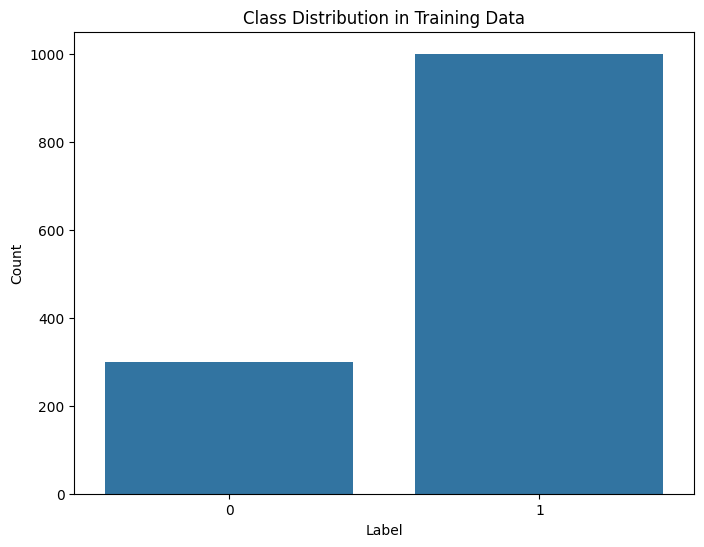

In [ ]:
climate_analysis.plot_class_distribution()


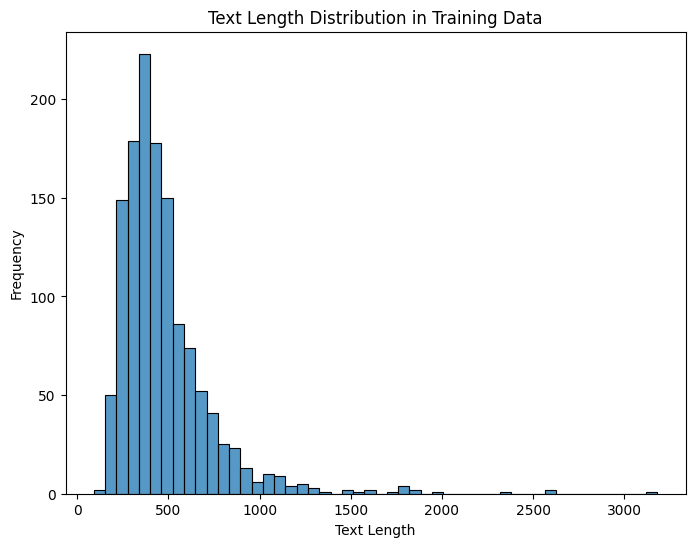

In [ ]:
climate_analysis.plot_text_length_distribution()



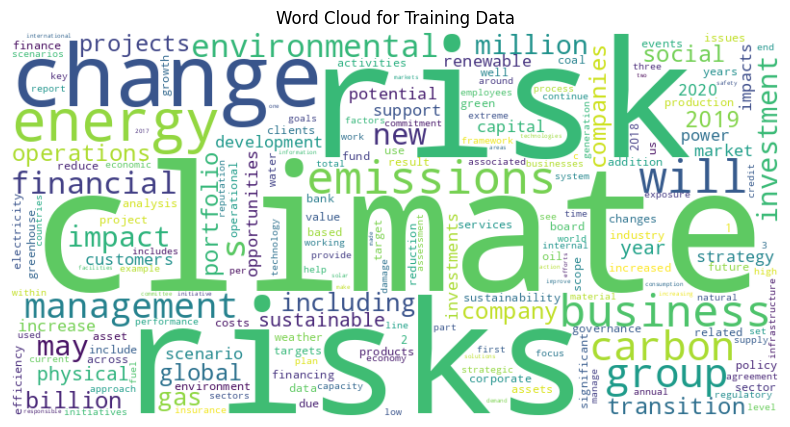

In [ ]:
climate_analysis.generate_word_cloud()



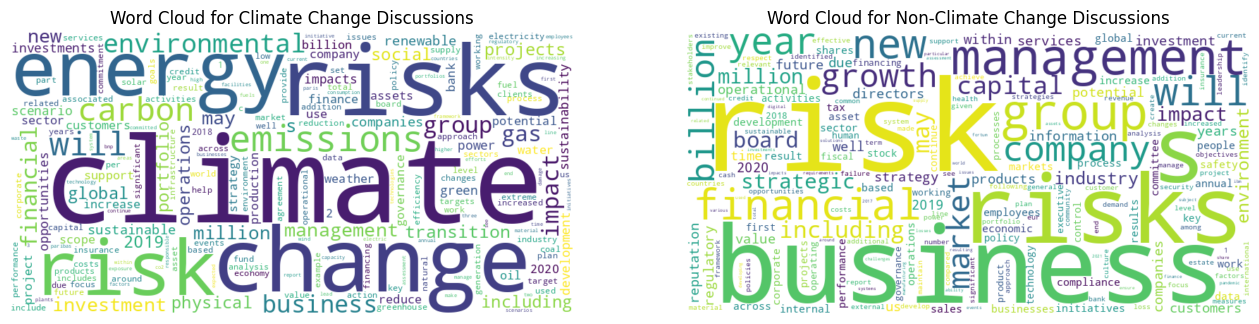

In [ ]:
climate_analysis.generate_label_word_clouds()


In [ ]:

climate_analysis.keyword_stats()


Keyword 'climate':
  - Appears in 42.20% of climate change texts
  - Appears in 0.67% of non-climate change texts
------------------------------
Keyword 'warming':
  - Appears in 2.20% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'emissions':
  - Appears in 22.70% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'carbon':
  - Appears in 25.40% of climate change texts
  - Appears in 0.00% of non-climate change texts
------------------------------
Keyword 'energy':
  - Appears in 24.80% of climate change texts
  - Appears in 2.00% of non-climate change texts
------------------------------
Keyword 'sustainability':
  - Appears in 8.40% of climate change texts
  - Appears in 1.00% of non-climate change texts
------------------------------


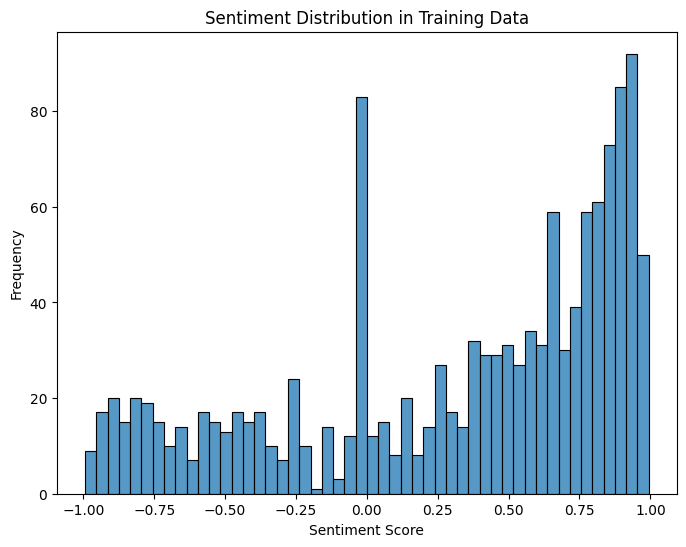

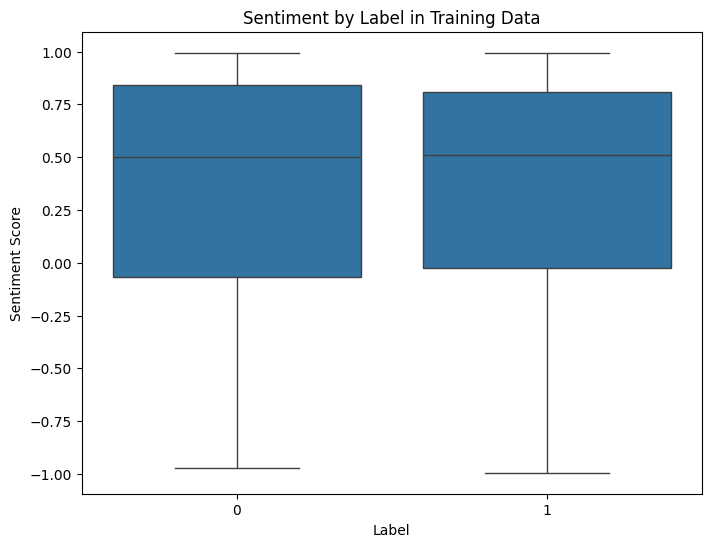

In [ ]:

climate_analysis.analyze_sentiment()


label  sentiment_cat
0      Negative         0.253333
       Neutral          0.073333
       Positive         0.673333
1      Negative         0.244000
       Neutral          0.074000
       Positive         0.682000
Name: text, dtype: float64


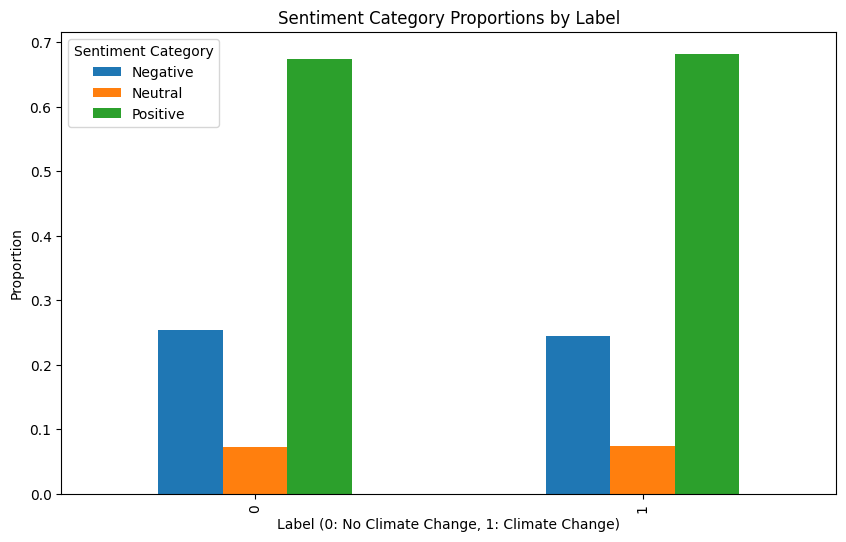

In [ ]:

climate_analysis.categorize_and_analyze_sentiment()



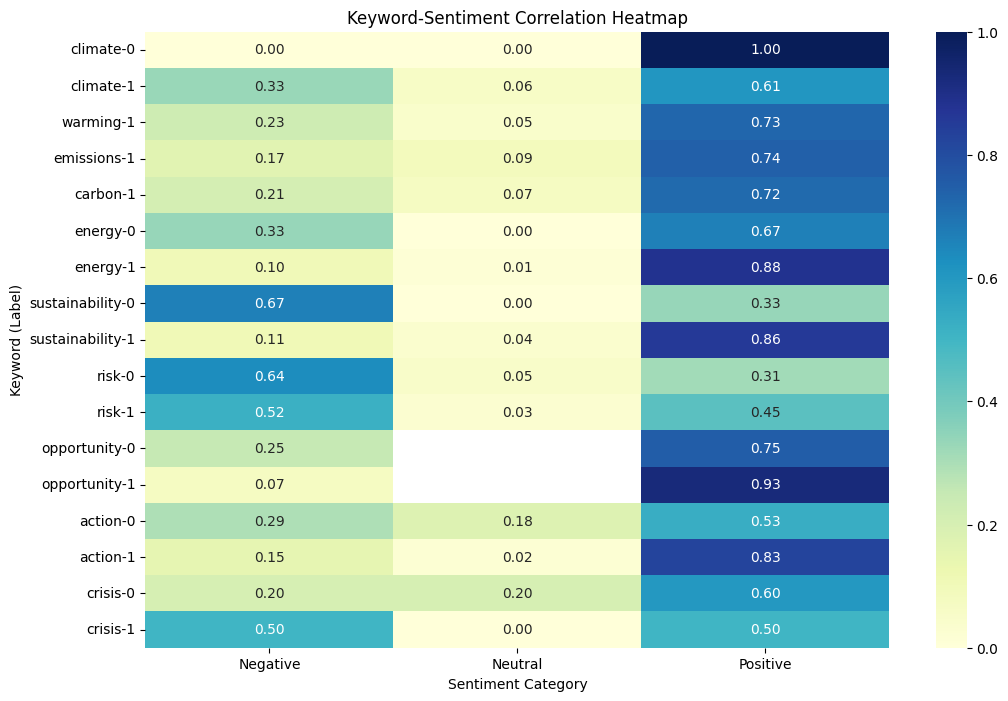

In [ ]:
climate_analysis.keyword_sentiment_analysis()


In [ ]:
climate_analysis.train_classifier()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.124601,0.965000,0.987261,0.968750,0.977918
2,No log,0.178543,0.960000,0.972050,0.978125,0.975078
3,No log,0.405424,0.930000,0.989933,0.921875,0.954693
4,0.149000,0.205565,0.962500,0.978056,0.975000,0.976526
5,0.149000,0.226536,0.960000,0.981013,0.968750,0.974843


Model saved at './content/saved_model'.


<ipython-input-17-d0679eaa23c7>:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Text: Climate change is a major issue that needs to be addressed.
Predicted Sentiment: Positive

Text: Renewable energy sources are the future.
Predicted Sentiment: Positive

Text: This winter was very cold.
Predicted Sentiment: Negative

Text: harsha is a good boy
Predicted Sentiment: Negative

Text: in the month of august its very hot
Predicted Sentiment: Negative

Text: business is very low in the moment
Predicted Sentiment: Negative



Evaluation Results: {'test_loss': 0.22653625905513763, 'test_runtime': 12.4132, 'test_samples_per_second': 32.224, 'test_steps_per_second': 4.028}


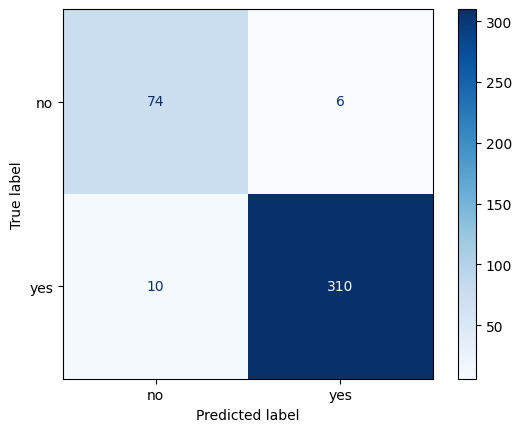

In [ ]:
sample_texts = [
        "Climate change is a major issue that needs to be addressed.",
        "Renewable energy sources are the future.",
        "This winter was very cold.",
        "harsha is a good boy",
        "in the month of august its very hot",
        "business is very low in the moment"

]

climate_analysis.predict_sample_sentiments(sample_texts)

climate_analysis.evaluate_classifier()
